In [1]:
import pandas as pd
import regex
import matplotlib.pyplot as mpl
from scipy.optimize import curve_fit
from collections import OrderedDict
from itertools import repeat
import numpy as np
import scipy.stats as st

# Number of meteorites studied:
N = 31929

df = pd.read_excel('MeteoriteData.xlsx')
df_coord = df['Coordinates']
df.dropna(inplace = True)
print(df)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


             Name     ID NameType        Classification  \
0          Aachen      1    Valid                    L5   
1          Aarhus      2    Valid                    H6   
2            Abee      6    Valid                   EH4   
3        Acapulco     10    Valid           Acapulcoite   
4         Achiras    370    Valid                    L6   
...           ...    ...      ...                   ...   
45711  Zillah 002  31356    Valid               Eucrite   
45712      Zinder  30409    Valid  Pallasite, ungrouped   
45713        Zlin  30410    Valid                    H4   
45714   Zubkovsky  31357    Valid                    L6   
45715  Zulu Queen  30414    Valid                  L3.7   

                            Mass   Fall                 Year  \
0          Quantity[21, "Grams"]   Fell                 1880   
1         Quantity[720, "Grams"]   Fell  1951-01-01 00:00:00   
2      Quantity[107000, "Grams"]   Fell  1952-01-01 00:00:00   
3        Quantity[1914, "Grams"]   

1. Make an histogram of the mass distribution of meteorites. Do it again for the meteorites having a mass less or equal to 50 000 grams.

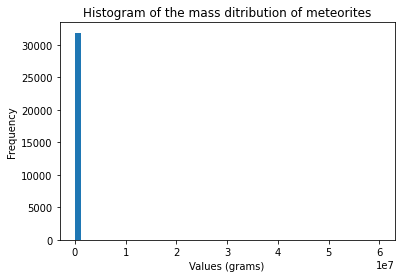

In [2]:
masses = []
for i in range(N):
    mass_col = df.iloc[i,4]
    mass_val = regex.findall('\d',mass_col)
    massAsAnInt = int("".join(mass_val))
    masses.append(massAsAnInt)

#print(masses)

mpl.hist(masses, bins = 50)
mpl.xlabel("Values (grams)")
mpl.ylabel("Frequency")
mpl.title("Histogram of the mass ditribution of meteorites")
mpl.show()

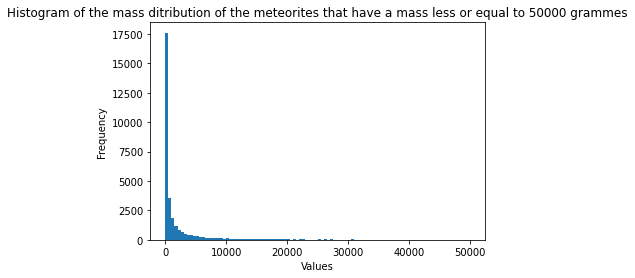

In [3]:
massesInfFifty = []
for i in range(len(masses)):
    if masses[i] <= 50000:
        massesInfFifty.append(masses[i])

mpl.hist(massesInfFifty, bins = 100)
mpl.xlabel("Values")
mpl.ylabel("Frequency")
mpl.title("Histogram of the mass ditribution of the meteorites that have a mass less or equal to 50000 grammes")
mpl.show()

2. Make a plot of the number of meteorites as a function of time (by year). Find a linear fit (y = ax + b) that approximates the trend of the curve. Using this function say what would be the number of landing meteorites next year. Is this approach of prediction scientifically robust?

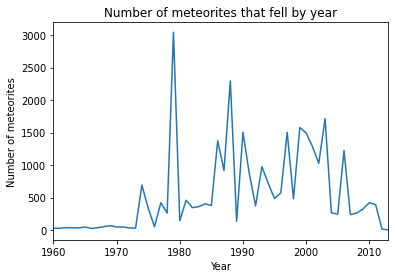

y = 1.03370 * x + -1808.20495
Number of meteorites that will fall in 2014: 274


In [4]:
year_list = []
year_count = []

for i in range(len(masses)):
    year_col = df.iloc[i,6]
    if isinstance(year_col, str) == True:
        year_list.append(int(year_col))
    else:
        year_list.append(year_col.year)

for year in year_list:
    year_count.append(year_list.count(year))

assemblage = zip(year_list, year_count)
assemblage = list(assemblage)
assemblage = sorted(assemblage, key = lambda x: x[0])
unique_list = list(OrderedDict(zip(assemblage, repeat(None))))

x, y = zip(*unique_list)

mpl.plot(x, y)
mpl.xlim(1960,2013)
mpl.xlabel('Year')
mpl.ylabel('Number of meteorites')
mpl.title('Number of meteorites that fell by year')
mpl.show()

def trend_curve(x,a,b):
    return a * x + b

popt, _ = curve_fit(trend_curve,x,y)
a,b = popt
print('y = %.5f * x + %.5f' % (a,b))

print("Number of meteorites that will fall in 2014:", round(trend_curve(2014,a,b)))


3. We will concentrate now in the case of Oman. Create a plot of this country with different points representing the spatial distribution of the landing sites.

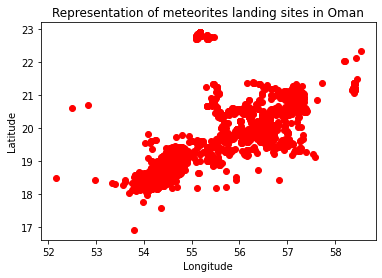

In [5]:
coordinates = {}
for i in range(N):
    col_coord = df.iloc[i,7]
    for j, car in enumerate(col_coord):
        if car == "{":
            start_x = j+1
    for k, car in enumerate(col_coord):
        if car == "," :
            end_x = k
            start_y = k+2
    for l, car in enumerate(col_coord):
        if car == "}" :
            end_y = l
    lng = float(col_coord[start_x:end_x])
    lat = float(col_coord[start_y:end_y])
    coordinates[lng] = lat

oman = {}
for x,y in coordinates.items():
    if x > 16.61 and x < 26.28:
        if y > 51.93 and y < 59.84:
            oman[x] = y

assemb = oman.items()
y, x = zip(*assemb)

mpl.scatter(x,y,c = '#FF0000')
mpl.xlabel('Longitude')
mpl.ylabel('Latitude')
mpl.title('Representation of meteorites landing sites in Oman')
mpl.show()

4. Propose a distribution (uniform, gaussian, cobinaison of different ones...) in order to describe the distribution of meteorite landing sites in Oman.

In [6]:
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

51.529939000000006 59.170711 16.327422 23.492358


Text(0.5, 1.0, '2D Gaussian Kernel density estimation')

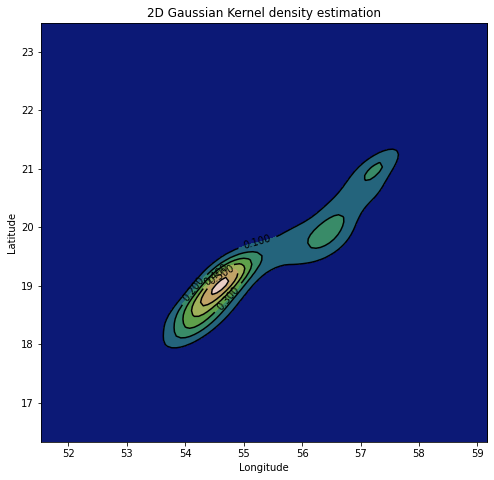

In [7]:
fig = mpl.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, f, cmap='gist_earth')
ax.imshow(np.rot90(f), cmap='gist_earth', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
mpl.title('2D Gaussian Kernel density estimation')

5. Based on that distribution compute the probability that a meteorite land in the circle of center {latitude,longitude}={18.9644, 53.9555} and radius equals to 100 Kilometers.

In [8]:
totalInCircle = 0
totalInOman = len(oman)

# Computing r based on observations made on google earth

r = ((19.0375-18.9644)**2+(54.9053-53.9555)**2)**0.5
print(r)
x = list(x)
y = list(y)
Xo = 18.9644
Yo = 53.9555

for i in range(len(oman)):
    Y = x[i]
    X = y[i]
    if((X - Xo)**2 + (Y - Yo)**2 <= r**2):
        totalInCircle += 1

print("Number of meteorites in Oman:", totalInOman)
print("Number of meteorites in the circle:", totalInCircle)
print("Probability that a meteorite fall in the circle:", totalInCircle/totalInOman)

0.9526088651697469
Number of meteorites in Oman: 2795
Number of meteorites in the circle: 1304
Probability that a meteorite fall in the circle: 0.4665474060822898
